# Setup

In [35]:
import random
!pip install python-crfsuite
import pycrfsuite
from sklearn.model_selection import train_test_split
import string
from tqdm.notebook import tqdm
from tabulate import tabulate

global folder
folder = "/content/drive/MyDrive/Afstudeerproject/"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
with open(folder + "Data/four_block.txt", "r") as f:
    all_citations = f.readlines()

with open(folder + "Data/three_block.txt", "r") as f:
    all_citations += f.readlines()

all_citations = [citation.replace("\n", "") for citation in all_citations]
random.shuffle(all_citations)

# Parsing

In [37]:
class Parser():
    def __init__(self, add_names=False) -> None:
        self.wrong_names = []
        self.add_names = add_names
        
        with open(folder + "Data/Wordlists/known_names.txt", "r") as f:
            self.known_names_list = f.readlines()
            self.known_names_list = [name.replace("\n", "") for name in self.known_names_list]
        
        with open(folder + "Data/Wordlists/surnames.txt", "r") as f:
            self.surnames_list = f.readlines()
            self.surnames_list = [name.replace("\n", "") for name in self.surnames_list]
        
        with open(folder + "Data/Wordlists/only_titles.txt") as f:
            self.title_names = f.readlines()
            self.title_names = [title.replace("\n", "") for title in self.title_names]
    

    def remove_front(self, sentence):
        while sentence[0] == " ":
            sentence = sentence[1:]
        
        return sentence


    def parse_citation(self, citation):
        if citation.count("/") > 0:
            citation = citation.replace("/", " ")
        else:
            citation = citation.replace("-", " ")
        self.parsed = []
        self.tokens = citation.split(", ")
        auflage = (0, False)
        for i, token in enumerate(self.tokens):
            if "Aufl" in token:
                auflage = (i, True)

        self.token_number = 0

        self.parse_names()

        if auflage[1]:
            while self.token_number < auflage[0]:
                self.parse_title()
            self.parse_edition()
        else:
            self.parse_title()

        while self.token_number < len(self.tokens):
            self.parse_entry()

        return self.parsed

    
    def parse_names(self):
        has_title = False
        names = self.remove_front(self.tokens[self.token_number])

        names = names.split(" ")
        authors = []
        editors = []
        in_token = False
        for name in names:
            if name == "in":
                in_token = True
            elif in_token:
                editors.append(name)
            else:
                authors.append(name)

        authors, wrong_authors = self.check_namelist(authors)
        editors, wrong_editors = self.check_namelist(editors)

        wrong = wrong_authors + wrong_editors
        total = [(author, "author") for author in authors]
        total += [(editor, "editor") for editor in editors]

        for wrong_name in wrong:
            if wrong_name in self.title_names:
                total += [(wrong_name, "title")]
                has_title = True
        
        for name_text in names:
            for name in total:
                if name[0] == name_text:
                    total.remove(name)
                    self.parsed.append(name)
                    break

        self.token_number += 1
        return True

    def check_namelist(self, names):
        correct_names = []
        wrong_names = []
        for name in names:
            if name == "":
                continue
            if name[0].islower():
                continue
            if name in self.known_names_list or name in self.surnames_list:
                correct_names.append(name)
            elif self.add_names:
                print(f"{name} is not in the namelist.\nShould this name be added to the namelist y/n?")
                choice = input()
                if choice.lower() == "y":
                    self.known_names_list.append(name)
                    self.surnames_list.append(name)
                    correct_names.append(name)
                    with open(folder + "Data/Wordlists/only_names.txt", "a") as f:
                        f.write(name + "\n")
                    print("Name added")
            else:
                wrong_names.append(name)
                self.wrong_names.append(name)

        return correct_names, wrong_names
    

    def parse_title(self):
        title = self.remove_front(self.tokens[self.token_number])

        title = title.split(" ")
        self.parsed += [(word, "title") for word in title]

        self.token_number += 1
        return True
    

    def parse_edition(self):
        edition = self.remove_front(self.tokens[self.token_number])

        edition = edition.split(" ")
        for token in edition:
            digits = 0
            for char in token:
                if char.isdigit():
                    digits += 1
            if digits == 4:
                self.parsed.append((token, "year"))
            else:
                self.parsed.append((token, "edition"))

        self.token_number += 1
        return True
    

    def parse_entry(self):
        entry = self.remove_front(self.tokens[self.token_number])
        entry = entry.split(" ")
        self.parsed += [(word, "entry") for word in entry]

        self.token_number += 1
        return True

# Featurizer

In [38]:
import string
import random

class Featurizer():
    def __init__(self, window=2, check_punct=False, position=False,
                 check_wordlist=False, check_namelist=False,
                 check_titlelist=False, add_token=False, all=False):
        self.window = window
        self.check_punct = check_punct or all
        self.position = position or all
        self.check_wordlist = check_wordlist or all
        self.check_namelist = check_namelist or all
        self.check_titlelist = check_titlelist or all
        self.add_token = add_token or all
        self.punctuation = string.punctuation
        self.randnumbers = ["Rn", "Rdnr", "Rdn", "Rz", "RdNr", "Rdz"]
        self.standard_features = {
                "caps": "None",
                "digits": "None",
                "is_four_digits": False,
                "isAufl": False,
                "isRand": False,
                "isIn": False,
                "isPar": False,
                "isBOS": False,
                "isEOS": False,
                "hasPunct": False,
            }

        if check_wordlist or all:
            with open("/content/drive/MyDrive/Afstudeerproject/Data/Wordlists/wordlist.txt", "r") as f:
                self.wordlist = f.readlines()
                self.wordlist = [word.replace("\n", "") for word in self.wordlist]

        if check_namelist or all:
            with open("/content/drive/MyDrive/Afstudeerproject/Data/Wordlists/known_names.txt", "r") as f:
                self.namelist = f.readlines()
                self.namelist = [name.replace("\n", "") for name in self.namelist]

            with open("/content/drive/MyDrive/Afstudeerproject/Data/Wordlists/surnames.txt", "r") as f:
                self.surnames = f.readlines()
                self.surnames = [name.replace("\n", "") for name in self.surnames]

        if check_titlelist or all:
            with open("/content/drive/MyDrive/Afstudeerproject/Data/Wordlists/only_titles.txt", "r") as f:
                self.titlelist = f.readlines()
                self.titlelist = [title.replace("\n", "") for title in self.titlelist]

    def featurize_citation(self, citation, parsed=[]):
        labeling = False
        if parsed:
            labeling = True
        if citation.count("/") > 0:
            citation = citation.replace("/", " ")
        else:
            citation = citation.replace("-", " ")
        citation = citation.split(" ")
        citation = ["BOS"] * self.window + citation + ["EOS"] * self.window
        featurized = []
        for i, token in enumerate(citation):
            if token == "" or token == " ":
                continue
            elif "," in token and token != ",":
                citation.insert(i + 1, ",")
                token = token.replace(",", "")
            token_features = self.standard_features.copy()
            if labeling:
                if token == "," and 1 - random.random() > 0.75:
                    continue
                for parsed_token in parsed:
                    if token == parsed_token[0]:
                        token_features["label"] = parsed_token[1]
                        parsed.remove(parsed_token)
                        break
                if "label" not in token_features:
                    token_features["label"] = "other"

            if self.add_token:
                token_features["token"] = token

            if self.position:
                token_features["position"] = (i - self.window)/(len(citation) - self.window * 2)

            token_features["length"] = len(token)

            self.check_chars(token, token_features)
            self.check_token(token, token_features)
            self.check_lists(token, token_features)

            featurized.append(token_features)

        featurized = self.add_window(featurized)

        return featurized

    def check_chars(self, token, token_features):
        caps = 0
        digits = 0
        for char in token:
            if char.isdigit():
                digits += 1
            elif char.isupper():
                caps += 1
            elif char in self.punctuation:
                token_features["hasPunct"] = True

        if digits > 0 and digits < len(token):
            token_features["digits"] = "mixed"
        elif digits == len(token):
            token_features["digits"] = "all"
        if digits == 4 and len(token) == 4:
            token_features["is_four_digits"] = True

        if token[0].isupper() and caps == 1:
            token_features["caps"] = "first"
        elif caps > 1 and caps < len(token):
            token_features["caps"] = "mixed"
        elif caps == len(token):
            token_features["caps"] = "all"

    def check_token(self, token, token_features):
        if "Aufl" in token:
            token_features["isAufl"] = True
        if token.replace(".", "") in self.randnumbers:
            token_features["isRand"] = True
        if token.replace(":", "") == "in":
            token_features["isIn"] = True
        if "§" in token:
            token_features["isPar"] = True
        if token == "BOS":
            token_features["isBOS"] = True
        if token == "EOS":
            token_features["isEOS"] = True

        return True

    def check_lists(self, token, token_features):
        if self.check_wordlist:
            token_features["inWordlist"] = False
            if token.lower() in self.wordlist:
                token_features["inWordlist"] = True

        if self.check_namelist:
            token_features["inNamelist"] = False
            token_features["inSurnamelist"] = False
            if token in self.namelist:
                token_features["inNamelist"] = True
            if token in self.surnames:
                token_features["inSurnamelist"] = True

        if self.check_titlelist:
            token_features["inTitlelist"] = False
            if token in self.titlelist:
                token_features["inTitlelist"] = True
        

        return True

    def add_window(self, featurized):
        windowed = []
        for i in range(self.window, len(featurized)-self.window):
            token_features = featurized[i].copy()
            for j in range(-self.window, self.window + 1):
                if j == 0:
                    continue
                window_token = featurized[i + j].copy()
                for feature in window_token:
                    if feature == "token" or feature == "label" or feature == "position":
                        continue
                    token_features[f"{j}:{feature}"] = window_token[feature]
            windowed.append(token_features)

        return windowed

# Create train and test data

In [39]:
def create_train_test(citations, add_names=False, limit=0):
    fitting = 0
    citation_parser = Parser(add_names=add_names)
    citation_featurizer = Featurizer(all=True)
    y = []
    X = []
    if limit > 0:
        citations = citations[:limit]
    for i in tqdm(range(len(citations))):
        citation = citations[i]
        og_citation = citation
        parsed = citation_parser.parse_citation(citation)
        featurized = citation_featurizer.featurize_citation(citation, parsed)

        citation_labels = []
        citation_tokens = []
        citation_features = []
        for token_features in featurized:
            label = token_features["label"]
            token = token_features["token"]
            del token_features["label"]
            citation_labels.append(label)
            citation_tokens.append(token)
            citation_features.append(token_features)

        X.append(citation_features)
        y.append({"tokens": citation_tokens, "labels": citation_labels, "citation": og_citation})
        fitting += 1
    
    return X, y

In [40]:
print(len(all_citations))

85010


In [41]:
training = random.choices(all_citations, k=5000)
for citation in training:
    if citation in all_citations:
        all_citations.remove(citation)
        break

In [42]:
print(len(all_citations))

80132


In [43]:
X_train, y_train = create_train_test(training)

  0%|          | 0/5000 [00:00<?, ?it/s]

## Adding JSON labelled

In [44]:
import json
with open(folder + "Data/Manual/labelled.json", "r") as f:
    labelled_citations = json.load(f)

In [45]:
for labelled in labelled_citations.copy():
    empty = 0
    for label in labelled:
        if len(labelled[label]) == 0:
            empty += 1
    if empty == 7:
        labelled_citations.remove(labelled)

In [46]:
citation_featurizer = Featurizer(all=True)

In [47]:
X = []
y = []
for labelled in labelled_citations:
    citation = labelled["citation"]
    if citation.count("/") > 0:
        citation = citation.replace("/", " ")
    else:
        citation = citation.replace("-", " ")
    featurized = citation_featurizer.featurize_citation(citation)
    og_citation = citation
    citation = citation.split(" ")
    title = False
    author = False
    for i, token_feature in enumerate(featurized):
        token = token_feature["token"]
        if "label" not in token_feature:
            token_feature["label"] = "other"
        for label in labelled:
            if label == "citation":
                continue
            if token in labelled[label]:
                token_feature["label"] = label
            if label == "entry" and token in labelled["title"] and not title:
                token_feature["label"] = "title"
                title = True
            if label == "editor" and token in labelled["author"] and not author:
                token_feature["label"] = "author"
                author = True
        featurized[i] = token_feature

    citation_labels = []
    citation_tokens = []
    citation_features = []
    for token_features in featurized:
        label = token_features["label"]
        token = token_features["token"]
        del token_features["label"]
        citation_labels.append(label)
        citation_tokens.append(token)
        citation_features.append(token_features)
        
    X.append(citation_features)
    y.append({"tokens": citation_tokens, "labels": citation_labels, "citation": og_citation})

In [48]:
X_train += X
y_train += y

In [49]:
X_test, y_test = create_train_test(random.choices(all_citations, k=len(X_train)//5))

  0%|          | 0/1040 [00:00<?, ?it/s]

# Model training

In [50]:
y_train_labels = [citation["labels"] for citation in y_train]
y_test_labels = [citation["labels"] for citation in y_test]

In [51]:
trainer = pycrfsuite.Trainer(verbose=True)

trainer.set_params({
    'c1': 0.6,   # coefficient for L1 penalty
    'c2': 0.9,  # coefficient for L2 penalty
    'max_iterations': 1500, 

    'feature.possible_transitions': True
})

for xseq, yseq in zip(X_train, y_train_labels):
    trainer.append(xseq, yseq)

model = trainer.train(folder + "Models/crf.model")

Streaminguitvoer ingekort tot de laatste 5000 regels.

***** Iteration #603 *****
Loss: 4040.363232
Feature norm: 22.882097
Error norm: 84.870783
Active features: 1775
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.379

***** Iteration #604 *****
Loss: 4040.331959
Feature norm: 22.882205
Error norm: 108.912040
Active features: 1774
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.374

***** Iteration #605 *****
Loss: 4040.291356
Feature norm: 22.881663
Error norm: 84.867055
Active features: 1772
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.374

***** Iteration #606 *****
Loss: 4040.254968
Feature norm: 22.881455
Error norm: 97.378896
Active features: 1772
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.380

***** Iteration #607 *****
Loss: 4040.218873
Feature norm: 22.880854
Error norm: 79.047364
Active features: 1771
Line se

# Model testing

In [52]:
from sklearn.metrics import accuracy_score

In [55]:
best_score = 0
best_itter = 0
log = ""
for itterations in range(500, 1000, 100):
    trainer = pycrfsuite.Trainer(verbose=True)

    trainer.set_params({
        'c1': 0.6,   # coefficient for L1 penalty
        'c2': 0.9,  # coefficient for L2 penalty
        'max_iterations': itterations, 

        'feature.possible_transitions': True
    })

    for xseq, yseq in zip(X_train, y_train_labels):
        trainer.append(xseq, yseq)
    print(log)
    model = trainer.train(folder + "Models/crf.model")
    tagger = pycrfsuite.Tagger()
    tagger.open(folder + "Models/crf.model")
    y_pred = [tagger.tag(xseq) for xseq in X_test]
    y_pred2 = [x for b in y_pred for x in b]
    y_test2 = [x for b in y_test_labels for x in b]
    score = accuracy_score(y_test2, y_pred2)
    log += f"Num of itterations: {itterations}, score: {score} \n"
    if score > best_score:
        best_itter = itterations

Streaminguitvoer ingekort tot de laatste 5000 regels.

***** Iteration #347 *****
Loss: 4060.367624
Feature norm: 22.956471
Error norm: 260.915011
Active features: 1819
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.400

***** Iteration #348 *****
Loss: 4060.167427
Feature norm: 22.954958
Error norm: 256.552719
Active features: 1821
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.394

***** Iteration #349 *****
Loss: 4060.027524
Feature norm: 22.956297
Error norm: 203.893098
Active features: 1820
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.398

***** Iteration #350 *****
Loss: 4059.849006
Feature norm: 22.954536
Error norm: 183.377002
Active features: 1820
Line search trials: 2
Line search step: 0.500000
Seconds required for this iteration: 0.389

***** Iteration #351 *****
Loss: 4059.712208
Feature norm: 22.955377
Error norm: 120.594451
Active features: 1819
Lin

In [56]:
print(log)

Num of itterations: 500, score: 0.9772280011245431Num of itterations: 600, score: 0.9768062974416644Num of itterations: 700, score: 0.9772280011245431Num of itterations: 800, score: 0.9770874332302502Num of itterations: 900, score: 0.9773685690188361


## Using test data

In [4]:
tagger = pycrfsuite.Tagger()
tagger.open(folder + "Models/crf.model")

In [ ]:
tagger = pycrfsuite.Tagger()
tagger.open("/content/drive/MyDrive/Afstudeerproject/Complete/Final_Model.model")

In [ ]:
y_pred = [tagger.tag(xseq) for xseq in X_test]
results = []
for i in range(len(X_test)):
    correctness = [label == pred for label, pred in zip(y_pred[i], y_test[i]["labels"])]
    data  = {
        "Token": y_test[i]["tokens"], 
        "Predicted as": y_pred[i], 
        "Labeled as": y_test[i]["labels"], 
        "Correctness": correctness
        }
    results += correctness
    #if i > 100 and i < 200:
    print(y_test[i]["citation"], "\n")
    table = tabulate(data, headers="keys", tablefmt="orgtbl")
    print(table)
    print("-" * 100)

print(f"{results.count(True)} correct out of {len(results)} cases = {round(results.count(True)/len(results), 4)} accuracy")

14407 correct out of 14677 cases = 0.9816 accuracy


## Using new data

In [31]:
citation_featurizer = Featurizer(all=True)

### One example

In [32]:
"Grüneberg" in citation_featurizer.namelist

True

In [33]:
citation = "Grüneberg in Palandt, BGB, 75. Aufl. § 291 BGB Rn. 4"

if citation.count("/") > 0:
    citation = citation.replace("/", " ")
else:
    citation = citation.replace("-", " ")

featurized = citation_featurizer.featurize_citation(citation)
tokens = []
for token in featurized:
    tokens.append(token["token"])

y_pred = tagger.tag(featurized)
data = {"Token": tokens, "Predicted as": y_pred}
table = tabulate(data, headers="keys", tablefmt="orgtbl")
print(table)

| Token     | Predicted as   |
|-----------+----------------|
| Grüneberg | author         |
| in        | other          |
| Palandt   | editor         |
| ,         | other          |
| BGB       | title          |
| ,         | other          |
| 75.       | edition        |
| Aufl.     | edition        |
| §         | entry          |
| 291       | entry          |
| BGB       | entry          |
| Rn.       | entry          |
| 4         | entry          |


### Using non-fitting citations

In [ ]:
with open(folder + "Data/known_name_citations.txt", 'r') as f:
    citations = f.readlines()
    all_citations = [citation.replace("\n", "") for citation in citations]

In [ ]:
random.shuffle(all_citations)
start = 0
amount = 50
for citation in all_citations[start:start + amount]:
    if "[" in citation:
        continue
    print(citation)
    if citation.count("/") > 0:
            citation = citation.replace("/", " ")
    else:
        citation = citation.replace("-", " ")
    featurized = citation_featurizer.featurize_citation(citation)
    tokens = []
    for token in featurized:
        tokens.append(token["token"])
    y_pred = tagger.tag(featurized)
    data = {"Token": tokens, "Predicted as": y_pred}
    table = tabulate(data, headers="keys", tablefmt="orgtbl")
    print(table)
    print("-" * 100)

# Better Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
y_pred2 = [x for b in y_pred for x in b]
y_test2 = [x for b in y_test_labels for x in b]

In [ ]:
sorted_labels = sorted(set(y_pred2), key=lambda name: name)

In [ ]:
sorted_labels

['author', 'edition', 'editor', 'entry', 'other', 'title', 'year']

In [ ]:
print(classification_report(y_test2, y_pred2, target_names=sorted_labels, digits=4))

              precision    recall  f1-score   support

      author     0.9814    0.9926    0.9869      1750
     edition     0.9922    0.9581    0.9748      2243
      editor     0.9562    0.9704    0.9632       540
       entry     0.9858    0.9914    0.9886      4767
       other     0.9832    0.9884    0.9858      3542
       title     0.9629    0.9611    0.9620      1619
        year     0.9640    0.9907    0.9772       216

    accuracy                         0.9816     14677
   macro avg     0.9751    0.9790    0.9769     14677
weighted avg     0.9817    0.9816    0.9816     14677



In [ ]:
x = confusion_matrix(y_test2, y_pred2, labels=sorted_labels)

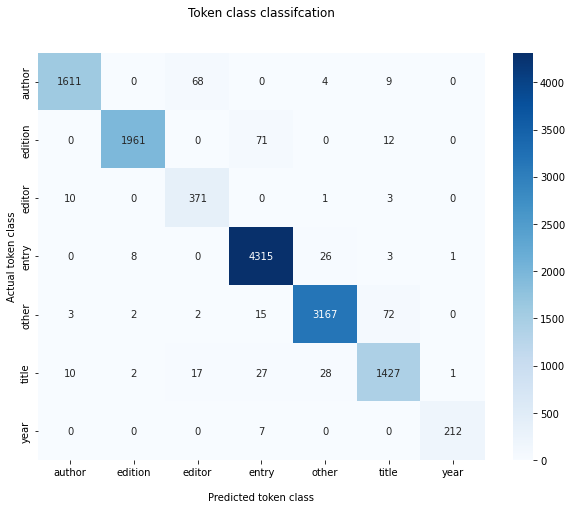

In [ ]:
plt.figure(figsize=(10,7.5))
ax = sns.heatmap(x, annot=True, cmap='Blues', fmt='g')
ax.set_title('Token class classifcation\n\n');
ax.set_xlabel('\nPredicted token class')
ax.set_ylabel('Actual token class');
ax.set_xticklabels(sorted_labels)
ax.set_yticklabels(sorted_labels)
plt.show()